# Imports
<div style="width:100%;height:0;border-bottom: 3px solid #F59A31;margin-bottom: 1rem;"></div>


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2 as cv
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

# Data & Visualization
### Note: brighter the area, farther it is in the image, brighter => more depth
<div style="width:100%;height:0;border-bottom: 3px solid #F7D735;margin-bottom: 1rem;"></div>


In [6]:
train_csv = Path('./nyu-depth-v2/nyu_data/data/nyu2_train.csv')
train_ims_path = Path('./nyu-depth-v2/nyu_data/data/nyu2_train')
base_path = Path('./nyu-depth-v2/nyu_data')

In [7]:
df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head()

,0,1
0,nyu-depth-v2\nyu_data\data\nyu2_train\living_r...,nyu-depth-v2\nyu_data\data\nyu2_train\living_r...
1,nyu-depth-v2\nyu_data\data\nyu2_train\living_r...,nyu-depth-v2\nyu_data\data\nyu2_train\living_r...
2,nyu-depth-v2\nyu_data\data\nyu2_train\living_r...,nyu-depth-v2\nyu_data\data\nyu2_train\living_r...
3,nyu-depth-v2\nyu_data\data\nyu2_train\living_r...,nyu-depth-v2\nyu_data\data\nyu2_train\living_r...
4,nyu-depth-v2\nyu_data\data\nyu2_train\living_r...,nyu-depth-v2\nyu_data\data\nyu2_train\living_r...


In [8]:
train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
len(train_df),len(val_df), len(test_df)

(45619, 4562, 507)

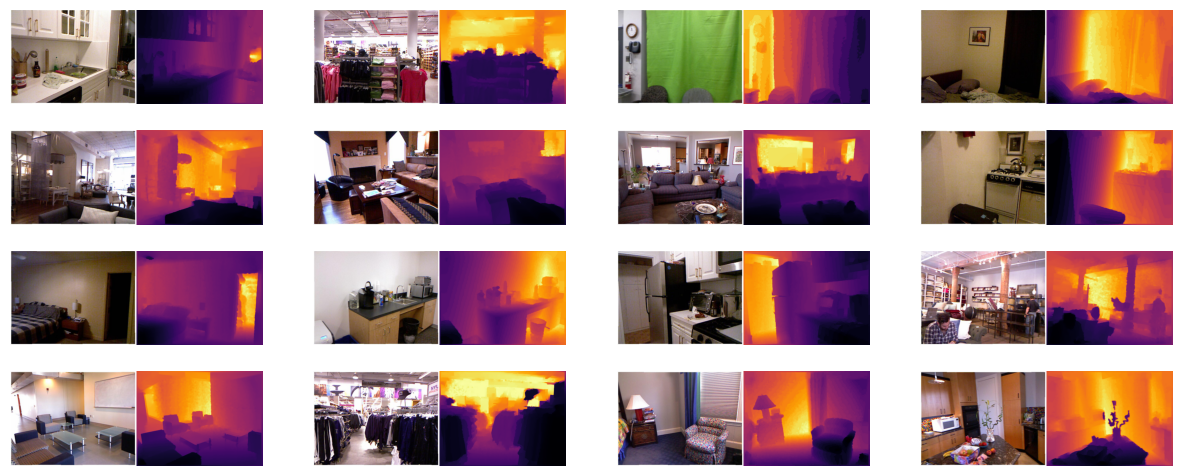

In [9]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# Dataset
<div style="width:100%;height:0;border-bottom: 3px solid #F7F437;margin-bottom: 1rem;"></div>


In [10]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384,384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])

In [11]:
class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)

In [12]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(45619, 4562, 507)

# Transforms Visualization
<div style="width:100%;height:0;border-bottom: 3px solid #DEF839;margin-bottom: 1rem;"></div>

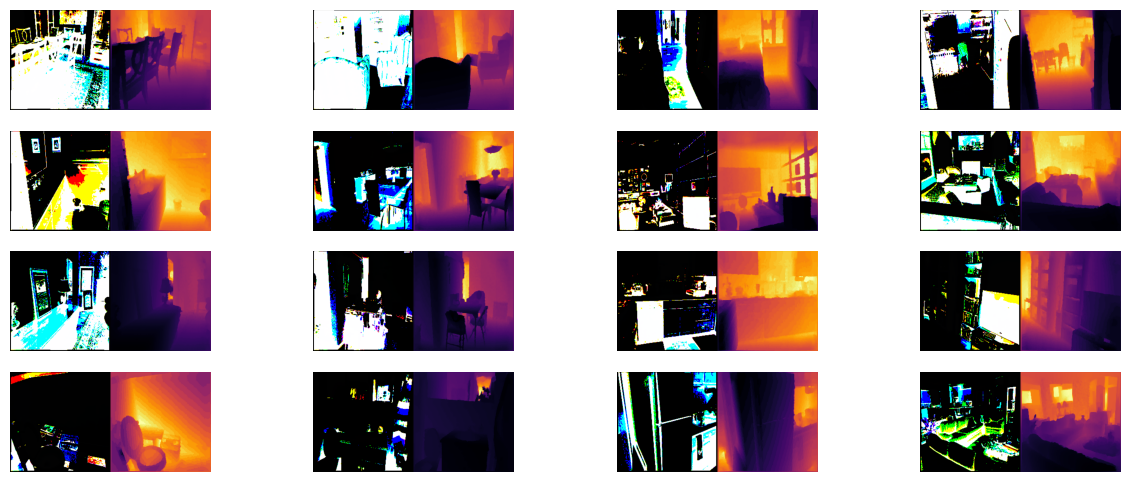

In [13]:
randoms = [test_ds[idx] for idx in range(16)]
plt.figure(figsize=(15, 6))
for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)
    img, mask = img.permute(1,2,0).numpy(), mask.permute(1,2,0).numpy()
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [14]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds,shuffle=False,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)
len(train_dl), len(val_dl), len(test_dl)

(713, 72, 127)

# Model
<div style="width:100%;height:0;border-bottom: 3px solid #C3F93B;margin-bottom: 1rem;"></div>

In [15]:
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name='resnext50_32x4d',
            in_channels=3,
            classes=1
        )
        
    def trainable_encoder(self,trainable=True):
        for p in self.model.encoder.parameters():
            p.requires_grad = trainable
        
    def forward(self,x):
        return self.model(x)
    
    def _num_params(self,):
        return sum([p.numel() for p in self.model.parameters() if p.requires_grad])

# Training
<div style="width:100%;height:0;border-bottom: 3px solid #F59A31;margin-bottom: 1rem;"></div>

### Metrics:

####  Structural Similarity Index (SSIM)

The structural similarity index (SSIM) is a perceptual metric that takes into account the structural similarity of the two images. SSIM is calculated by comparing the local patterns of the two images, taking into account the luminance, contrast, and structure of the images.

The formula for SSIM is:

$$ SSIM = \frac{(2 \mu_x \mu_y + c_1) (2 \sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1) (\sigma_x^2 + \sigma_y^2 + c_2)} $$

where μx​ and μy​ are the means of the two images, σx2​ and σy2​ are the variances of the two images, and σxy​ is the covariance of the two images. c1​ and c2​ are constants that are used to stabilize the calculation of SSIM.

SSIM is more robust to noise and small changes than MSE, but it is also more computationally expensive to calculate.

In general, SSIM is preferred over MSE for image quality assessment because it provides a more accurate measure of how humans perceive the similarity of two images. However, MSE is still a useful metric, especially when speed is important.

In [16]:
class UnNormalize(Normalize):
    def __init__(self,*args,**kwargs):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets,n=4,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img)*255.
        img,pred,gt = img.permute(1,2,0).numpy(), pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img,pred,gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/target/prediction' if len(title)!=0 else 'image/target/prediction'
    plt.suptitle(title)
    plt.show()

In [17]:
epochs = 5
freeze_epochs = 2
lr = 1e-3

device = 'cuda'

metrics = MetricCollection([
    SSIM(data_range=(0,1)),
    MSE()
]).to(device)
train_metrics = metrics.clone()
val_metrics = metrics.clone()

logs = pd.DataFrame()
logs[['loss_train','loss_val','ssim_train','ssim_val','mse_train','mse_val']]=None

model = UNet().to(device)
model.trainable_encoder(trainable=False)

loss_fn = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(),lr=lr / 25.,weight_decay=0.02)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=lr,epochs=epochs,steps_per_epoch=(len(train_dl)))

scaler = GradScaler()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to C:\Users\ANONYMOUS/.cache\torch\hub\checkpoints\resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:10<00:00, 9.89MB/s]


training decoder only


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]



  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
0   0.028754  0.008635   0.566229  0.729036  0.028759  0.008655




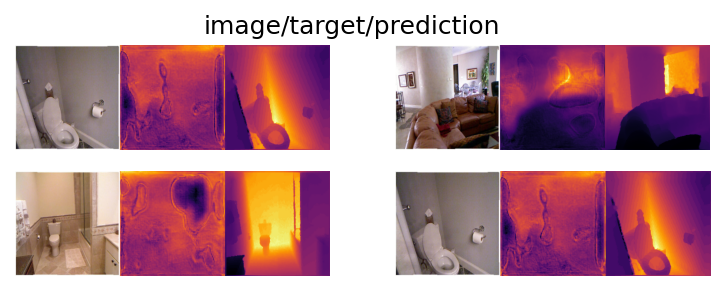

  0%|          | 0/713 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
best_ssim = -1e9
best_epoch = -1

print('training decoder only')

for epoch in tqdm(range(epochs)):
    
    model.train()
    
    if epoch == freeze_epochs:
        model.trainable_encoder(trainable=True)
        print('training encoder and decoder both')
    
    running_loss = 0.
    train_prog = tqdm(train_dl,total=len(train_dl))
    
    for img, mask in train_prog:
        
        with autocast():
            img, mask = img.to(device), mask.to(device)
            preds = model(img)

            loss = loss_fn(preds,mask)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad()

            running_loss += loss.item()

            train_prog.set_description(f'loss: {loss.item():.3f}')
            train_metrics(preds,mask)
        
        del img, mask, preds, loss

    m = train_metrics.compute()
    _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
    logs.loc[epoch,['loss_train','ssim_train','mse_train']] = (running_loss/len(train_dl),_ssim,_mse)
    train_metrics.reset()
    model.eval()
    
    with torch.no_grad():
        
        running_loss = 0.
        
        val_prog = tqdm(val_dl,total=len(val_dl))
        for img, mask in val_prog:

            with autocast():
                img, mask = img.to(device), mask.to(device)
                preds = model(img)
                loss = loss_fn(preds,mask)
                running_loss += loss.item()
                val_prog.set_description(f'loss: {loss.item():.3f}')
                
                val_metrics(preds, mask)
                
            del img, mask, preds, loss
            
        m = val_metrics.compute()
        _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
        logs.loc[epoch,['loss_val','ssim_val','mse_val']] = (running_loss/len(val_dl),_ssim,_mse)
        val_metrics.reset()
    
    if _ssim > best_ssim:
        best_ssim = _ssim
        best_epoch = epoch
        sd = model.state_dict()
        torch.save(sd,'nyu-v2-depth-resnext50_32x4d-unetplusplus.pt')
        
    print(f"\n\n{logs.tail(1)}\n\n")
    
    with torch.no_grad():
        with autocast():
            img, mask = next(iter(test_dl))
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            plot_vals(
                img.cpu(),
                preds.cpu(),
                mask.cpu()
            )
        
    gc.collect()
    torch.cuda.empty_cache()

# Predictions
<div style="width:100%;height:0;border-bottom: 3px solid #F7D735;margin-bottom: 1rem;"></div>

In [19]:
best_epoch

0

In [20]:
best_sd = torch.load('/kaggle/working/nyu-v2-depth-resnext50_32x4d-unetplusplus.pt')
model.load_state_dict(best_sd)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/nyu-v2-depth-resnext50_32x4d-unetplusplus.pt'

In [ ]:
all_imgs, all_preds, all_targets = [], [], []
with torch.no_grad():
    with autocast():
        for img, mask in tqdm(test_dl,total=len(test_dl)):
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            all_imgs.append(img)
            all_preds.append(preds)
            all_targets.append(mask)

test_metrics = metrics.clone()
test_metrics(
    torch.vstack(all_preds),
    torch.vstack(all_targets)
)
m = test_metrics.compute()
title = f"SSIM: {m['StructuralSimilarityIndexMeasure'].cpu().item():.3f} MSE: {m['MeanSquaredError'].cpu().item():.3f}"
plot_vals(
    torch.vstack(all_imgs).cpu(),
    torch.vstack(all_preds).cpu(),
    torch.vstack(all_targets).cpu(),
    n=16,
    figsize=(10,15),
    title=title
)

# Results
<div style="width:100%;height:0;border-bottom: 3px solid #8DFA3F;margin-bottom: 1rem;"></div>

In [ ]:
logs

In [ ]:
logs['loss_train'].plot()
logs['loss_val'].plot()
plt.title('loss : lower = better')
plt.legend()
plt.show()

In [ ]:
logs['mse_train'].plot()
logs['mse_val'].plot()
plt.title('mse : lower = better')
plt.legend()
plt.show()

In [ ]:
logs['ssim_train'].plot()
logs['ssim_val'].plot()
plt.title('ssim : higher = better')
plt.legend()
plt.show()